Building pre-trained LSTM model (shear stress prediction) for Transfer learning on p5271 experiment

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(),
                    'A_filt':data['A_filt'].ravel(), 'T_pc':data['T_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

df = df1.drop(['Time'], axis=1)   # Drop irrelevant features
print("Input data:\n", df)


Input data:
              V_filt  Vel_pc       A_filt  T_pc        SS
0       5489.978529     0.0  1804.180000   0.0  5.656166
1       5489.981454     0.0  1803.666667   0.0  5.657157
2       5489.997639     0.0  1803.314286   0.0  5.658317
3       5490.007016     0.0  1803.437500   0.0  5.659499
4       5490.000189     0.0  1803.266667   0.0  5.660404
...             ...     ...          ...   ...       ...
132394  5459.380488     0.0  1784.250000   0.0  5.471059
132395  5459.377762     0.0  1784.055556   0.0  5.474545
132396  5459.388352     0.0  1783.837500   0.0  5.478286
132397  5459.398820     0.0  1783.371429   0.0  5.481751
132398  5459.399041     0.0  1781.433333   0.0  5.484813

[132399 rows x 5 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132099, 300, 4)
Target shape, Y =  (132099,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 300, 4)
Validation: (10568, 300, 4)
Testing: (26420, 300, 4)


Epoch 1/10
2973/2973 [==============================] - 63s 21ms/step - loss: 0.9703 - val_loss: 0.0233
Epoch 2/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0166 - val_loss: 0.0226
Epoch 3/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0104 - val_loss: 0.0032
Epoch 4/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/10
2973/2973 [==============================] - 59s 20ms/step - loss: 6.3905e-04 - val_loss: 0.0014
Epoch 7/10
2973/2973 [==============================] - 59s 20ms/step - loss: 4.9970e-04 - val_loss: 9.8138e-04
Epoch 8/10
2973/2973 [==============================] - 58s 19ms/step - loss: 4.0623e-04 - val_loss: 6.0779e-04
Epoch 9/10
2973/2973 [==============================] - 58s 20ms/step - loss: 3.6754e-04 - val_loss: 6.2558e-04
Epoch 10/10
2973/2973 [=============

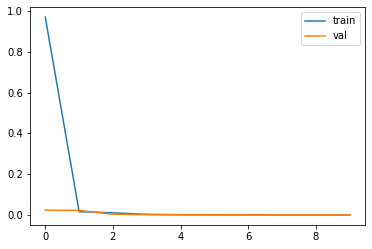

---Training time: 602.86012459 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(1)

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 32)           4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 7,889
Trainable params: 7,889
Non-trainable params: 0
_________________________________________________________________
None


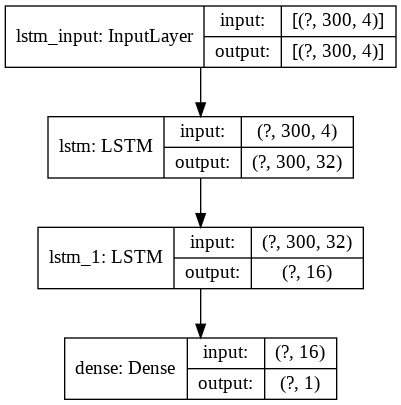

In [ ]:
# Save the model

print(model.summary())
plot_model(model, show_shapes=True)
model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/Transfer_LSTM_ss.h5')

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.97560, Validation - 0.97843, Test - 0.95715
RMSE scores: Train - 0.02008, Validation - 0.02167, Test - 0.02991

---Time for Test data prediction: 7.50496697 seconds ---
